In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg


In [2]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []

    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [3]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
    pieces.append(signal[end:])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    return pieces_padded

In [4]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    return [dis12/dis21, A0/A1]

(4718, 1000) (2822, 6)


0it [00:00, ?it/s]

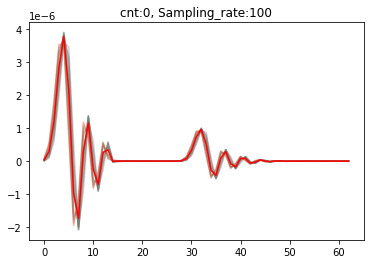

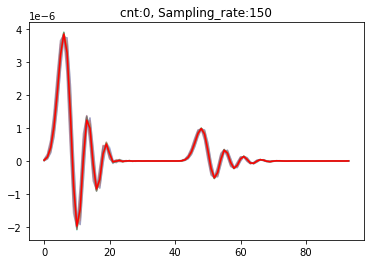

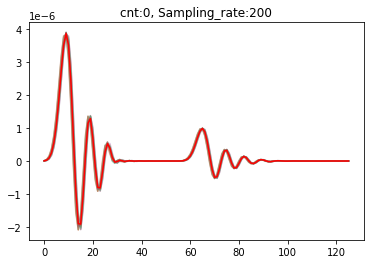

1it [00:00,  1.89it/s]

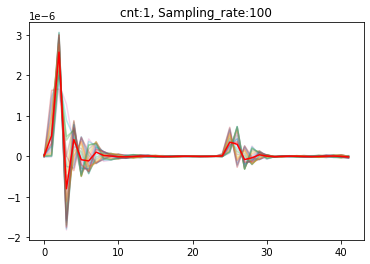

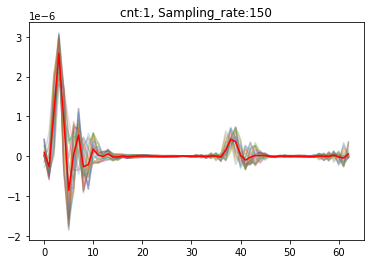

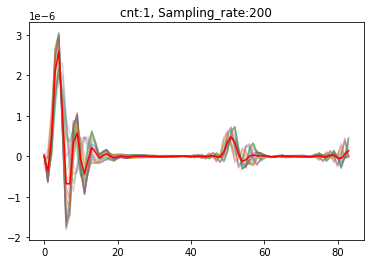

2it [00:01,  1.91it/s]

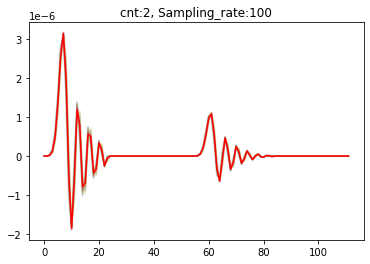

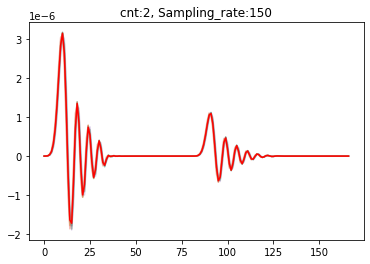

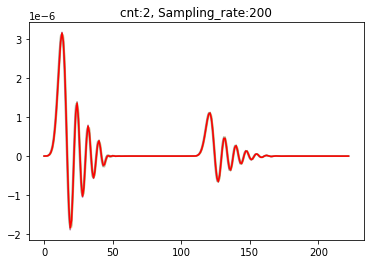

3it [00:01,  1.96it/s]

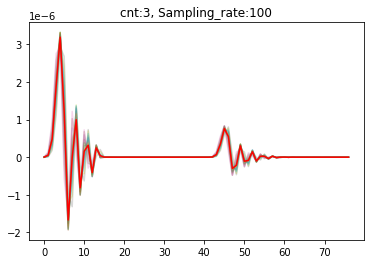

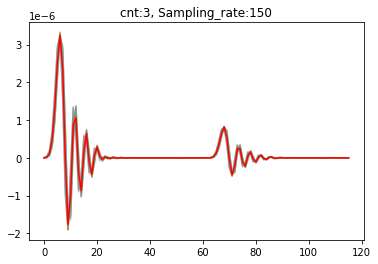

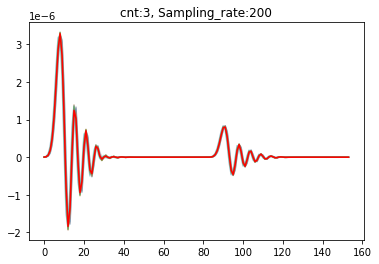

4it [00:02,  1.43it/s]

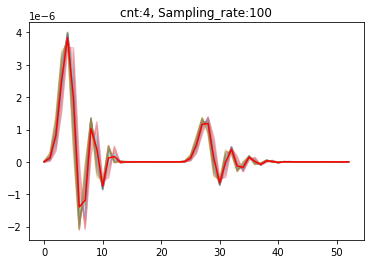

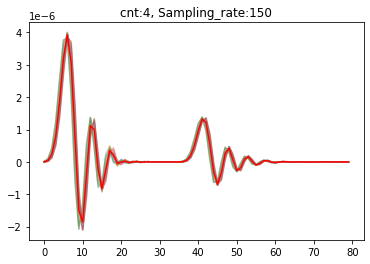

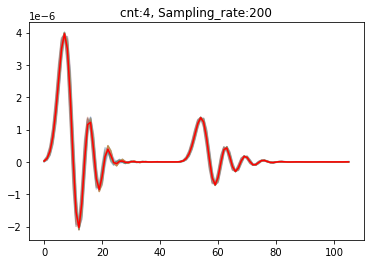

5it [00:03,  1.39it/s]

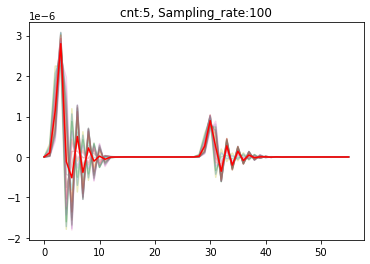

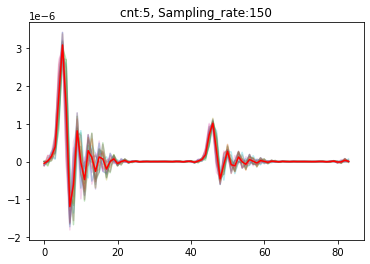

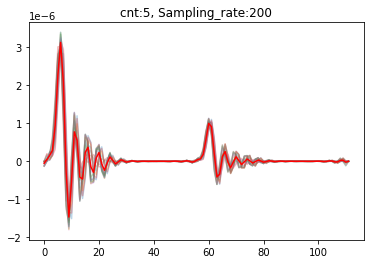

6it [00:04,  1.38it/s]

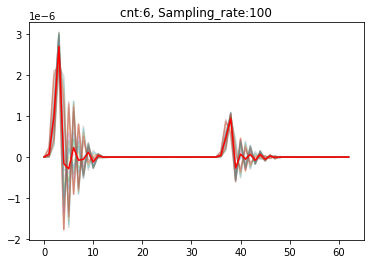

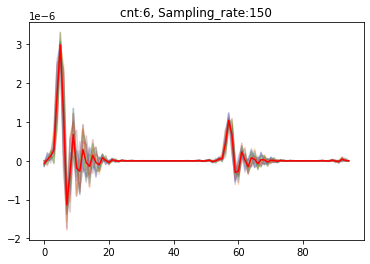

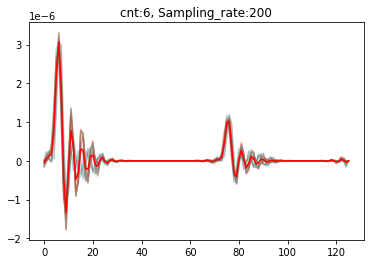

7it [00:04,  1.41it/s]

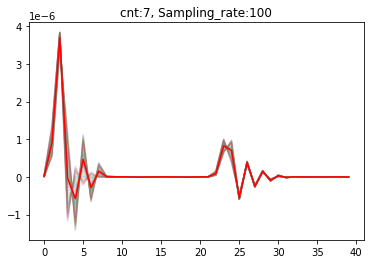

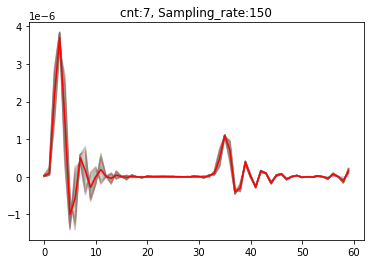

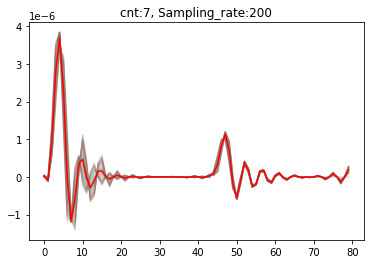

8it [00:05,  1.39it/s]

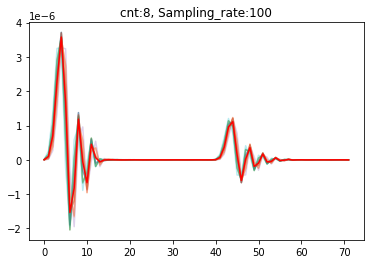

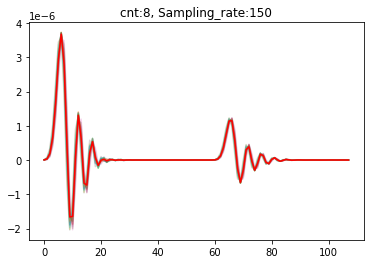

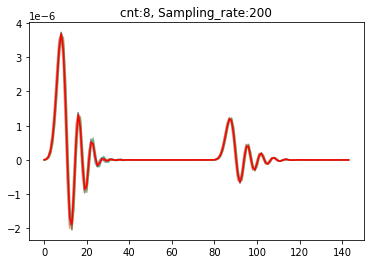

9it [00:06,  1.47it/s]

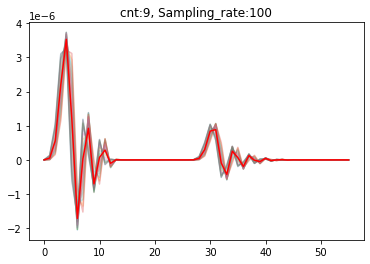

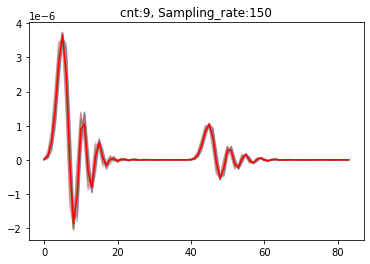

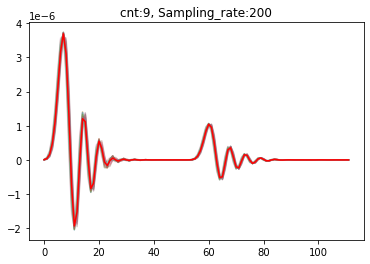

10it [00:06,  1.50it/s]

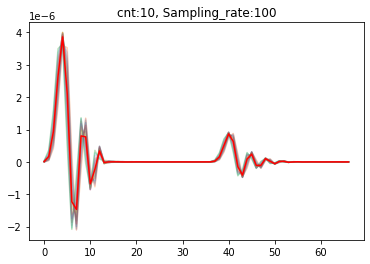

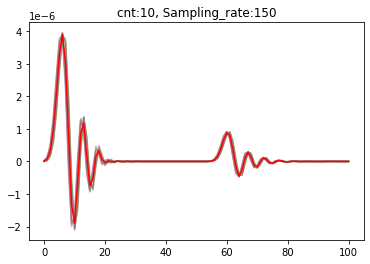

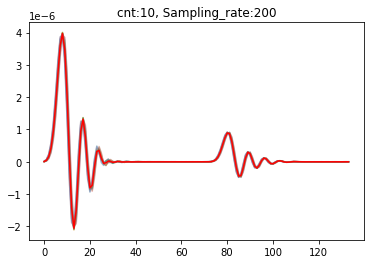

11it [00:07,  1.48it/s]

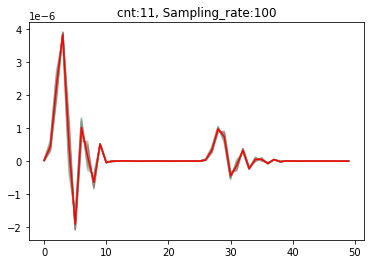

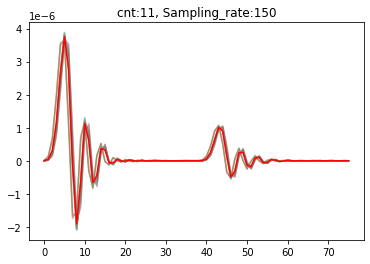

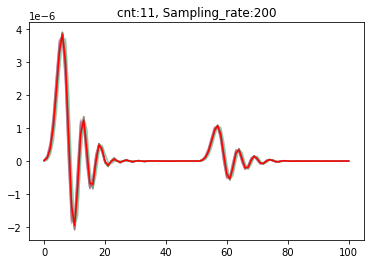

11it [00:08,  1.35it/s]
0it [00:00, ?it/s]

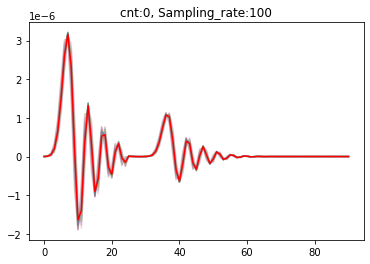

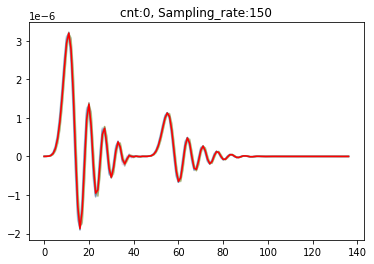

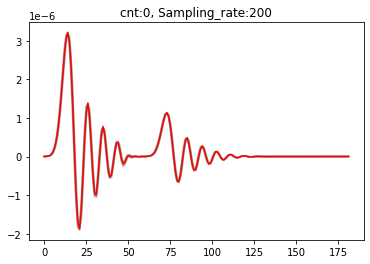

1it [00:00,  1.17it/s]

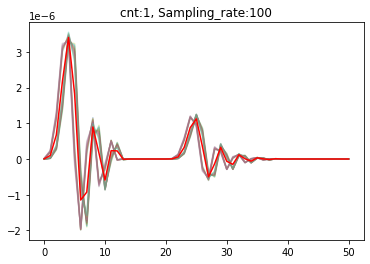

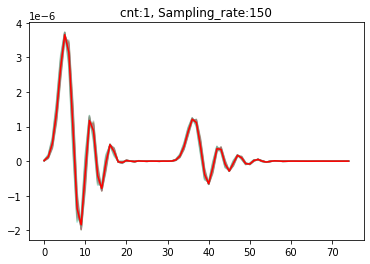

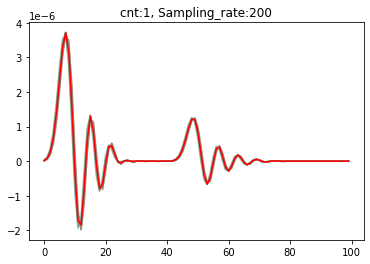

2it [00:01,  1.32it/s]

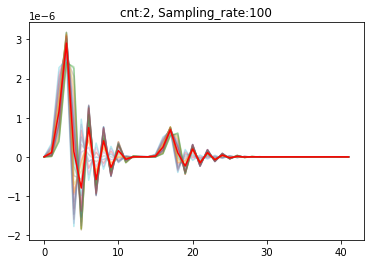

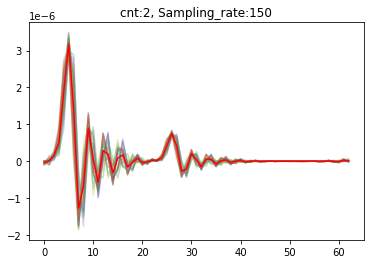

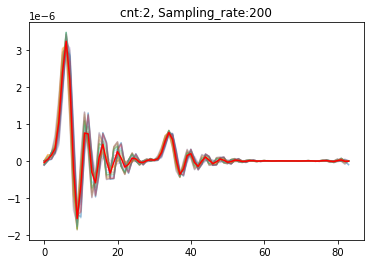

3it [00:02,  1.36it/s]

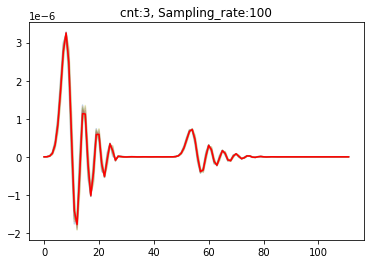

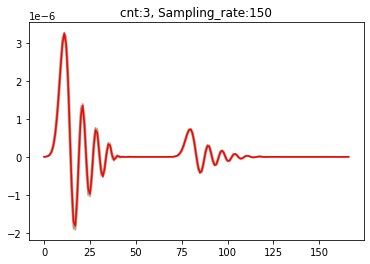

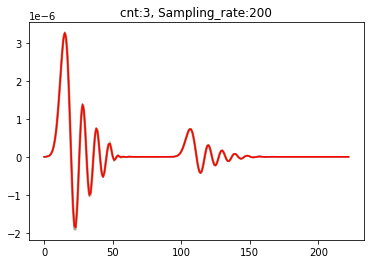

4it [00:02,  1.50it/s]

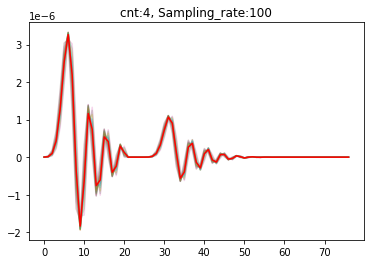

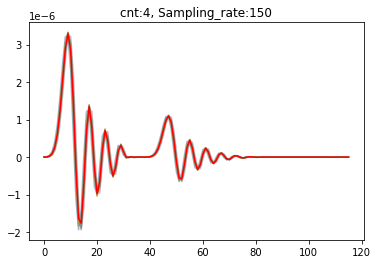

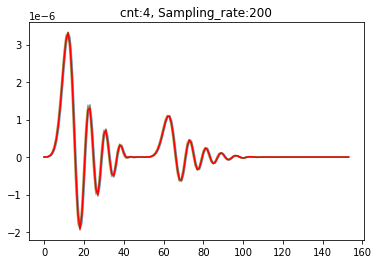

4it [00:03,  1.11it/s]


In [9]:
from tqdm import tqdm
# from dtw.dtw import dtw
# import random
from scipy.signal import resample, resample_poly
import matplotlib.gridspec as gridspec
from Code.DTW.dba.DBA import performDBA

if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    # labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    def extract_features(signals, labels, alpha, h, d, echo):
        Template_features = []
        idxs = []
        D = []
        for cnt, signal_ in tqdm(enumerate(signals)):
            hr = labels[cnt, 2]
            ddd = labels[cnt, -1]
            D.append(ddd)

            signal100 = signal_
            large_peaks100, _ = find_peaks(signal100, height=np.max(signal100)*0.3, distance=5000//(hr*alpha))
            signal150 = resample_poly(signal_, 1500, 1000)
            large_peaks150, _ = find_peaks(signal150, height=np.max(signal150)*0.3, distance=7500//(hr*alpha))
            signal200 = resample_poly(signal_, 2000, 1000)
            large_peaks200, _ = find_peaks(signal200, height=np.max(signal200)*0.3, distance=10000//(hr*alpha))

            pieces100 = segmentation(signal100, large_peaks100)
            pieces150 = segmentation(signal150, large_peaks150)
            pieces200 = segmentation(signal200, large_peaks200)




            plt.figure()
            plt.title(f'cnt:{cnt}, Sampling_rate:{100}')
            for s in pieces100:
                plt.plot(range(0,len(s)), s, alpha=0.3)
            plt.plot(np.array(pieces100).mean(0), color='r', label='template')
            plt.savefig(f'D:\PHD\Presentation\Pics\\1212\cnt{cnt}_SamplingRate_{100}' )
            plt.show()

            plt.figure()
            plt.title(f'cnt:{cnt}, Sampling_rate:{150}')
            for s in pieces150:
                plt.plot(range(0,len(s)), s, alpha=0.3)
            plt.plot(np.array(pieces150).mean(0), color='r', label='template')
            plt.savefig(f'D:\PHD\Presentation\Pics\\1212\cnt{cnt}_SamplingRate_{150}' )
            plt.show()

            plt.figure()
            plt.title(f'cnt:{cnt}, Sampling_rate:{200}')
            for s in pieces200:
                plt.plot(range(0,len(s)), s, alpha=0.3)
            plt.plot(np.array(pieces200).mean(0), color='r', label='template')
            plt.savefig(f'D:\PHD\Presentation\Pics\\1212\cnt{cnt}_SamplingRate_{200}' )
            plt.show()
            if cnt > echo:
                break

        return np.array(Template_features), np.array(idxs)

    echo1 = 10
    echo2 = 3
    template_features_train, idxs_train = extract_features(signals_0_train, labels_0_train, 1, 0.1, 0.15, echo1)
    template_features_test, idxs_test = extract_features(signals_0_test, labels_0_test, 1.2, 0.12, 0.12, echo2)

In [37]:
from tqdm import tqdm
# from dtw.dtw import dtw
# import random
from scipy.signal import resample, resample_poly
import matplotlib.gridspec as gridspec
from Code.DTW.dba.DBA import performDBA

if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    # labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    def extract_features(signals, labels, alpha, h, d, echo):
        Template_features = []
        idxs = []
        D = []
        for cnt, signal_ in tqdm(enumerate(signals)):
            hr = labels[cnt, 2]
            ddd = labels[cnt, -1]
            D.append(ddd)

            signal100 = signal_
            large_peaks100, _ = find_peaks(signal100, height=np.max(signal100)*0.3, distance=5000//(hr*alpha))
            signal150 = resample_poly(signal_, 1500, 1000)
            large_peaks150, _ = find_peaks(signal150, height=np.max(signal150)*0.3, distance=7500//(hr*alpha))
            signal200 = resample_poly(signal_, 2000, 1000)
            large_peaks200, _ = find_peaks(signal200, height=np.max(signal200)*0.3, distance=10000//(hr*alpha))

            pieces100 = segmentation(signal100, large_peaks100)
            pieces150 = segmentation(signal150, large_peaks150)
            pieces200 = segmentation(signal200, large_peaks200)

            template100 = performDBA(pieces100)
            template150 = performDBA(pieces150)
            template200 = performDBA(pieces200)

            # pieces_np = np.array(pieces)
            # template = pieces_np.mean(0)

            features = get_features(template, h, d)
            if features is not None:
                idxs.append(cnt)
                Template_features.append(features)

            # plt.figure()
            # for s in pieces:
            #     plt.plot(range(0,len(s)), s, alpha=0.3)
            # plt.plot(template, color='r', label='template')
            # plt.show()

            show = False

            if show:
                if cnt > 1:
                    fig = plt.figure(tight_layout=True)
                    gs = gridspec.GridSpec(2, 6)
                    ax = fig.add_subplot(gs[:, :3])
                    ax.scatter(np.array(Template_features)[:-1, 1], D[:-1])
                    ax.scatter(features[1], ddd, color='r')

                    ax = fig.add_subplot(gs[0, 3:])
                    for s in pieces:
                        ax.plot(range(0,len(s)), s, alpha=0.3)
                    ax.plot(template, color='r', label='DBA')
                    # ax.legend()

                    ax = fig.add_subplot(gs[1, 3:])
                    ax.plot(template, color='r', label='DBA')
                    pieces_np = np.array(pieces)
                    ax.plot(pieces_np.mean(0) , label='Mean')

                    plt.show()

            # if cnt > echo:
            #     break

        return np.array(Template_features), np.array(idxs)

    echo1 = 5
    echo2 = 3
    template_features_train, idxs_train = extract_features(signals_0_train, labels_0_train, 1, 0.1, 0.15, echo1)
    template_features_test, idxs_test = extract_features(signals_0_test, labels_0_test, 1.2, 0.12, 0.12, echo2)

(4718, 1000) (2822, 6)


9it [00:15,  1.75s/it]


KeyboardInterrupt: 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()


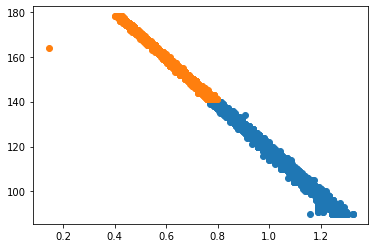

0.6480465383959297


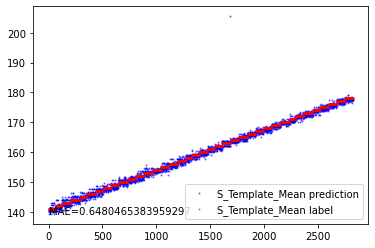

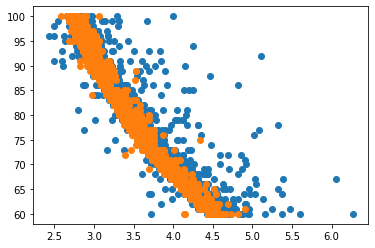

2.0718433403032446


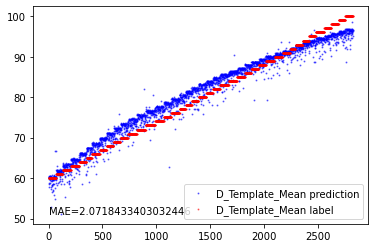

In [32]:
from sklearn.linear_model import LinearRegression as LR
# from Code.Tutorial.utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(template_features_train[:, 0],template_features_test[:, 0],labels_0_train[:, 4],labels_0_test[:, 4],'S_Template_Mean')
plot_plot(template_features_train[:, 1],template_features_test[:, 1],labels_0_train[:, 5],labels_0_test[:, 5],'D_Template_Mean')

In [23]:
template_features_train[:, 0].shape,template_features_test[:, 0].shape,labels_0_train[:11, 4].shape,labels_0_test[:11, 4].shape

((12,), (12,), (11,), (11,))